Notebook to analyse the data regarding the aggregate SBP adoption before 2008 and the one during the Portuguese Carbon Fund project (PCF project) and merging them into a dataset reporting the SBP adoption from 1996 to 2012.

**Requirements**: numpy pandas xlrd openpyxl

## Content
* PCF project: retrieve adoption over each municipality
* Merge of adoption previous and during PCF -> Yearly SBP adoption per municipality
* Plot pre-PCF vs PCF adoption for disaggregation check
* Other datasets construction:
    * Cumulative adoption in each year
    * Yearly and cumulative for Portugal
* Datasets merging for machine learning models
* Create datasets with relative values of adoption refferd to permanent pasture area
    * Create and save dataset with % adoption in munic for ABM initialisation
    * Save datasets for ABM validation

In [1]:
import numpy as np
import pandas as pd

In [2]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
import os
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="jpeg", resolution=200):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Data ingestion and manipulation

In [4]:
path_to_PCF_data = "./PCF project data_Corrected counties.xlsx"
path_to_adoption_pre_PCF = "./SBP adoption previous to 2009 per municipality_PCF mapped.xlsx"

In [5]:
out_file = "./Final SBP adoption datasets/SBP yearly adoption + adoption features_PCF mapped.csv"
out_path_adoption_percentage = "./Final SBP adoption datasets/SBP % yearly adoption + % adoption features_PCF mapped.csv"

## PCF project

In [6]:
PCF_data = pd.read_excel(path_to_PCF_data, index_col=0)
#PCF_data.head()

In [7]:
PCF_data = PCF_data.drop('Farmer_ID', axis=1)

In [8]:
PCF_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1113 entries, 55 to 1048
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Year that the pasture was installed  1113 non-null   int64  
 1   County                               1113 non-null   object 
 2   Area_Total_SIG_PPI_2009_ha           1113 non-null   float64
 3   Area_Total_SIG_PPI_2010_ha           1113 non-null   float64
 4   Area_Total_SIG_PPII_2011_ha          1113 non-null   float64
 5   Area_Total_SIG_PPII_2012_ha          1113 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 60.9+ KB


### Check years have only values from 2009 to 2014

In [9]:
PCF_data['Year that the pasture was installed'].value_counts()

2010    310
2012    289
2009    279
2011    235
Name: Year that the pasture was installed, dtype: int64

### Check if any parcel adopted in multiple years, i.e. if any has two non zero values in the total area adopted each year

In [10]:
cols_with_area = ['Area_Total_SIG_PPI_2009_ha', 
                 'Area_Total_SIG_PPI_2010_ha', 
                 'Area_Total_SIG_PPII_2011_ha', 
                 'Area_Total_SIG_PPII_2012_ha']

number_of_year_adopted = len(cols_with_area) - (PCF_data[cols_with_area] == 0).sum(axis=1)

In [11]:
adopted_1_year = number_of_year_adopted == 1
all(adopted_1_year)

False

In [12]:
# Number of parcels which have correctly one adoption
sum(adopted_1_year)

1100

In [13]:
adopted_0_years = number_of_year_adopted == 0
sum(adopted_0_years)

13

Therefore, there are 1100 for which we have the area adopted and 13 for which we have not data on the area adopted that we can exclude.

In [14]:
parcels_without_adoption = PCF_data[adopted_0_years]
parcels_without_adoption.head()

,Year that the pasture was installed,County,Area_Total_SIG_PPI_2009_ha,Area_Total_SIG_PPI_2010_ha,Area_Total_SIG_PPII_2011_ha,Area_Total_SIG_PPII_2012_ha
Parcel_ID,,,,,,
414,2010,Évora,0.0,0.0,0.0,0.0
359,2010,Alcácer do Sal,0.0,0.0,0.0,0.0
106,2009,Arraiolos,0.0,0.0,0.0,0.0
249,2009,Alter do Chão,0.0,0.0,0.0,0.0
1061,2012,Vila Viçosa,0.0,0.0,0.0,0.0


In [15]:
PCF_data = PCF_data.drop(parcels_without_adoption.index)

In [16]:
len(PCF_data)

1100

Since each parcel adopted in one year and the DataFrame has a column for the year of adoption, we can substitute the last columns with the area of adoption with just one columns having the area adopted in any year.

In [17]:
PCF_data[cols_with_area].max(axis=1)
PCF_data['Area'] = PCF_data[cols_with_area].max(axis=1)

In [18]:
PCF_data = PCF_data.drop(cols_with_area, axis=1)

In [19]:
PCF_data.head()

,Year that the pasture was installed,County,Area
Parcel_ID,,,
55,2009,Idanha-a-Nova,9.28
410,2010,Évora,3.21
681,2011,Évora,6.83
1068,2012,Reguengos de Monsaraz,38.17
584,2010,Avis,9.57


### Get municipality adoption per municipality, per year

In [20]:
munic_adoption_MI = PCF_data.groupby(['County', 'Year that the pasture was installed']).sum()
#munic_adoption_MI.head()

Rearrange to have the years as a columns and bring in the same format as the SBP adoption previous to the PCF project

In [21]:
munic_adoption_PCF = munic_adoption_MI.unstack(fill_value=0)
#munic_adoption_PCF.head()

In [22]:
munic_adoption_PCF.columns.names = (None, None)
#munic_adoption_PCF.head()

In [23]:
munic_adoption_PCF.index.name = 'Municipality'

In [24]:
munic_adoption_PCF.columns = munic_adoption_PCF.columns.droplevel()
#munic_adoption_PCF.head()

In [25]:
len(munic_adoption_PCF)

73

### Retrieve list of municipalities which adopted during the PCF project

In [31]:
munic_adoption_PCF_list = munic_adoption_PCF.index.tolist()

In [32]:
## SBP adoption previous to the PCF project

munic_adoption_pre_PCF = pd.read_excel(path_to_adoption_pre_PCF, index_col=0)
#munic_adoption_pre_PCF

len(munic_adoption_pre_PCF)

278

In [33]:
import csv

with open("municipalities_adoption_PCF.csv", "w+") as file:
    wr = csv.writer(file)
    wr.writerow(munic_adoption_PCF_list)

## SBP adoption previous to the PCF project

In [34]:
munic_adoption_pre_PCF = pd.read_excel(path_to_adoption_pre_PCF, index_col=0)
#munic_adoption_pre_PCF

In [35]:
len(munic_adoption_pre_PCF)

278

# Municipalities comparison 

In [36]:
munic_PCF = munic_adoption_PCF.index.tolist()
munic_pre_PCF = munic_adoption_pre_PCF.index.tolist()

In [37]:
munic_in_PCF_not_in_prePCF = [munic for munic in munic_PCF if munic not in munic_pre_PCF]
munic_in_PCF_not_in_prePCF

[]

In [38]:
munic_in_prePCF_not_in_PCF = [munic for munic in munic_pre_PCF if munic not in munic_PCF]
len(munic_in_prePCF_not_in_PCF)

205

## Dataset merging

In [39]:
munic_adoption = pd.concat([munic_adoption_pre_PCF, munic_adoption_PCF], axis=1)

In [40]:
munic_adoption[munic_adoption.isna()] = 0

In [41]:
munic_adoption.index.name = 'Municipality'

Add a columns for 1995 with all 0s, since adoption values in 1995 serves to predict the adoption in 1996.

In [42]:
munic_adoption.insert(0, 1995, 0)

## Save dataset

In [43]:
file_munic_adoption = "./Final SBP adoption datasets/Yearly SBP adoption per municipality.xlsx"

In [44]:
munic_adoption.to_excel(file_munic_adoption)

In [47]:
munic_adoption.shape

(278, 18)

# Other datasets construction

## Cumulative SBP adoption per municipality

In [63]:
cumulative_total_munic_adoption = munic_adoption.cumsum(axis=1)
#cumulative_total_munic_adoption

Save file

## Datasets for Portugal

Dataset reporting for Portugal both the yearly adoption and the cumulative adoption

In [64]:
portugal_adoption = pd.DataFrame(columns=cumulative_total_munic_adoption.columns)

In [65]:
portugal_adoption.loc['Yearly adoption'] = munic_adoption.sum()
portugal_adoption.loc['Total cumulative adoption'] = cumulative_total_munic_adoption.sum()

In [66]:
portugal_adoption

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Yearly adoption,0.0,1682.0,1953.5,3968.0,3930.5,3922.5,5327.0,7839.0,10789.0,12419.0,8081.0,7431.0,9993.0,5967.0,12585.72,15485.48,9571.6,14136.67
Total cumulative adoption,0.0,1682.0,3635.5,7603.5,11534.0,15456.5,20783.5,28622.5,39411.5,51830.5,59911.5,67342.5,77335.5,83302.5,95888.22,111373.70,120945.3,135081.97


Save file

<AxesSubplot:>

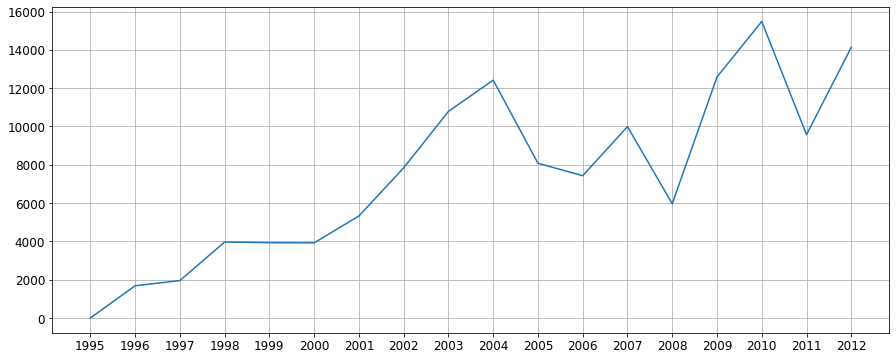

In [67]:
portugal_adoption.loc['Yearly adoption'].plot(figsize=(15,6), xticks=portugal_adoption.columns, grid=True)

# Datasets merging for machine learning models

To train the machine learnig models, we need a dataset having one row for each municipality for each year. The label is the adoption in that year. The features are all the datasets contructed above and refer to the previous year.

In [68]:
def multiindex_from_dataframe_columns(df, col_name, previous_year=False):
    """
    Function to create a multiindex from a dataframe, with the columns of the dataframe becoming the second level of the 
    multiindex.
    """
    keys = df.index.tolist()
    years = [y for y in df.columns.tolist() if y !=1995]
    mi = pd.MultiIndex.from_product([keys, years])
    mi = mi.to_frame()
    mi.drop(mi.columns, axis=1, inplace=True)
    for key in keys:
        for year in years:
            if previous_year:
                mi.loc[(key, year), col_name] = df.loc[key, year-1]
            else:
                mi.loc[(key, year), col_name] = df.loc[key, year]
    return mi

In [69]:
labels = multiindex_from_dataframe_columns(munic_adoption, 'adoption_in_year')

## Add features

### Total cumulative adoption previous year municipality

The cumulative adoptions are including the year of the columns, therefore need to be added considering this (previous_year=True)

In [70]:
tot_cum_adoption_previous_year_munic = multiindex_from_dataframe_columns(cumulative_total_munic_adoption,
                                                                        'tot_cumul_adoption_pr_y_munic',
                                                                        previous_year=True)

### Concatenate datasets with yearly values

In [71]:
datasets = [labels, tot_cum_adoption_previous_year_munic]

In [72]:
SBP_adoption_final = pd.concat(datasets, axis=1)

In [73]:
SBP_adoption_final.index.rename(['Municipality', 'Year'], inplace=True)

### Add Portugal cumulative adoption until the previous year

In [75]:
from itertools import cycle

def add_col_depending_on_year_not_on_munic(final_dataset, df_rows_to_append, cols_names):
    values = df_rows_to_append.transpose().to_numpy()
    values = np.reshape(values, (len(values), 1))
    yearly_values = cycle(values)
    final_dataset[cols_names] = [next(yearly_values) for i in range(len(final_dataset))]

In [76]:
cols_to_append = portugal_adoption.loc['Total cumulative adoption', 1995:2011]
cols_names = ['tot_cumul_adoption_pr_y_port']

add_col_depending_on_year_not_on_munic(SBP_adoption_final, cols_to_append, cols_names)

## Remove São João da Madeira (since no permanent pastures)

In [77]:
to_drop = ['São João da Madeira']
SBP_adoption_final.drop(to_drop, level='Municipality', inplace=True)

# Save final dataset

In [78]:
SBP_adoption_final.to_csv(out_file)

# Create datasets with relative values of adoption referred to permanent pastures area

In [80]:
path_to_pasture_area = "../census/extracted/municipalities_reference_permanent_pastures_area.csv"

In [81]:
pasture_area_munic = pd.read_csv(path_to_pasture_area, index_col='Municipality')

In [82]:
pasture_area_munic.head(2)

,pastures_area_munic_ha
Municipality,
Arouca,2602.0
Castelo de Paiva,74.0


In [83]:
cols = SBP_adoption_final.columns

In [84]:
SBP_perc_adoption_final = pd.DataFrame(index=SBP_adoption_final.index, columns=cols)

### Create and save dataset with % adoption in munic for ABM

In [85]:
munic_perc_yearly_adoption = munic_adoption.divide(
    pasture_area_munic['pastures_area_munic_ha'], axis=0, level='Municipality'
)

In [86]:
munic_perc_yearly_adoption[2013] = 0.
munic_perc_yearly_adoption[2014] = 0.

In [87]:
out_path_munic_perc_yearly_adoption = "./Final SBP adoption datasets/For ABM initialisation/% yearly SBP adoption per municipality.csv"

In [88]:
munic_perc_yearly_adoption.to_csv(out_path_munic_perc_yearly_adoption)

### Add columns on single municipality

In [89]:
cols_munic = ['adoption_in_year', 'tot_cumul_adoption_pr_y_munic']

In [90]:
SBP_perc_adoption_final[cols_munic] = SBP_adoption_final[cols_munic].divide(
    pasture_area_munic['pastures_area_munic_ha'], axis=0, level='Municipality'
)

Checks

In [91]:
all(SBP_perc_adoption_final.loc['Grândola', 'tot_cumul_adoption_pr_y_munic'] == (
    SBP_adoption_final.loc['Grândola', 'tot_cumul_adoption_pr_y_munic'] / pasture_area_munic.loc['Grândola'].values
))

True

In [92]:
#Any NaN?
SBP_perc_adoption_final[SBP_perc_adoption_final[cols_munic].isnull().any(axis=1)].index.get_level_values('Municipality').unique()

Index([], dtype='object', name='Municipality')

### Add columns for Portugal

In [93]:
pasture_area_port = sum(pasture_area_munic['pastures_area_munic_ha'])

In [94]:
cols_port = [col for col in cols if 'port' in col]

In [95]:
SBP_perc_adoption_final[cols_port] = SBP_adoption_final[cols_port].divide(
    pasture_area_port, axis=0, level='Municipality'
)

Checks

In [96]:
all(SBP_perc_adoption_final.loc[:, 'tot_cumul_adoption_pr_y_port'] == (
    SBP_adoption_final.loc[:, 'tot_cumul_adoption_pr_y_port'] / pasture_area_port
))

True

#### Final check: are there values over 1?

In [97]:
SBP_perc_adoption_final.loc[SBP_perc_adoption_final['tot_cumul_adoption_pr_y_munic'] > 1].index.get_level_values('Municipality').unique()

Index([], dtype='object', name='Municipality')

No more values over 1

In [98]:
rows_over_1 = SBP_perc_adoption_final.loc[SBP_perc_adoption_final['tot_cumul_adoption_pr_y_munic'] > 1]
munic_over_1 = rows_over_1.index.get_level_values(0).unique().to_list()
munic_over_1

[]

In [99]:
rows_over_05 = SBP_perc_adoption_final.loc[SBP_perc_adoption_final['tot_cumul_adoption_pr_y_munic'] > 0.5]
munic_over_05 = rows_over_05.index.get_level_values(0).unique().to_list()
munic_over_05

['Vagos', 'Tomar', 'Alcochete']

In [100]:
SBP_perc_adoption_final.loc[SBP_perc_adoption_final['tot_cumul_adoption_pr_y_munic'] > 0.5]

adoption_in_year  tot_cumul_adoption_pr_y_munic  \
Municipality Year                                                    
Vagos        2008          0.129313                       0.775880   
             2009          0.000000                       0.905193   
             2010          0.000000                       0.905193   
             2011          0.000000                       0.905193   
             2012          0.000000                       0.905193   
Tomar        2004          0.101392                       0.521869   
             2005          0.142147                       0.623260   
             2006          0.040755                       0.765408   
             2007          0.067594                       0.806163   
             2008          0.020875                       0.873757   
             2009          0.000000                       0.894632   
             2010          0.000000                       0.894632   
             2011          0.000000                       0.894632   
             2012          0.000000                       0.894632   
Alcochete    2012          0.197347                       0.526093   

                   tot_cumul_adoption_pr_y_port  
Municipality Year                                
Vagos        2008                      0.044921  
             2009                      0.048387  
             2010                      0.055698  
             2011                      0.064693  
             2012                      0.070253  
Tomar        2004                      0.022893  
             2005                      0.030106  
             2006                      0.034800  
             2007                      0.039117  
             2008                      0.044921  
             2009                      0.048387  
             2010                      0.055698  
             2011                      0.064693  
             2012                      0.070253  
Alcochete    2012                      0.070253

In [101]:
len(SBP_perc_adoption_final.loc[(SBP_perc_adoption_final == 0).all(axis=1)])

146

## Save file adoption percentual

In [102]:
SBP_perc_adoption_final.to_csv(out_path_adoption_percentage)

# Save datasets for ABM validation

#### Portugal level

In [103]:
out_path_port_adoption = "./Final SBP adoption datasets/For ABM validation/SBP yearly adoption - Portugal.csv"
portugal_adoption.loc['Yearly adoption'].to_csv(out_path_port_adoption)

#### Municipality level

In [104]:
tot_cumul_adoption_munic = multiindex_from_dataframe_columns(cumulative_total_munic_adoption, 
                                                             'tot_cumul_adoption_until_year_ha',
                                                              previous_year=False)

In [106]:
munic_adoption = pd.concat([SBP_perc_adoption_final['adoption_in_year'],
                            SBP_adoption_final['adoption_in_year'],
                            tot_cumul_adoption_munic],
                           axis=1)
munic_adoption.columns = ['adoption_in_year', 'adoption_in_year_ha', 'tot_cumul_adoption_until_year_ha']
munic_adoption.index.names = ['Municipality', 'Year']

In [107]:
out_path_munic_adoption = "./Final SBP adoption datasets/For ABM validation/SBP yearly adoption - Municipalities.csv"
munic_adoption.to_csv(out_path_munic_adoption)